![alt text](../img/lenet2.png)

![alt text](../img/lenet_table.png)

Мы рассмотрим архитектуру LeNet, она не самая лучшая, но она довольно логичная.

- Сперва у нас подаётся изображение размером 32 на 32. В MNIST изображения 28 на 28, мы с этим тоже немножко поработаем. 
- Это изображение прогоняется через свёртку 5 на 5, с шестью выходными каналами, значит - у нас свёртка 5 на 5 проходит по всему изображению. У неё нулевые паддинги, то есть она не выходит за границы изображения, и по этой причине она обрезает два пикселя с каждой стороны изображения, и выходное изображение от 32 на 32 преобразуется к изображению 28 на 28. 
- Но теперь это уже не изображение а тензор глубиной 6, потому что свёртка - с шестью выходными каналами. 
- После этого тензор (28 на 28 на 6) передается в average pooling (сейчас уже, в принципе, так не делают - уже везде используют max pooling, но здесь ещё используется average pooling), который вычисляет среднее значение по квадрату 2 на 2. Он по всему изображению проходит со страйдом 2 (то есть он берёт непересекающиеся участки 2 на 2), и вычисляет среднее значение пикселей или чисел, которые оказываются в этом тензоре. 
- И на выходе у него один пиксель, соответственно, всё изображение ужимается в два раза: было 28 на 28 на 6, стало 14 на 14 на 6. 
- Далее повторяется точно такая же свёртка, как в первый раз, только теперь у неё количество входных каналов - 6, а выходных каналов - 16. При этом, из 14 на 14, изображение получается 10 на 10, потому что у нас по два пикселя съелось с каждой стороны, потому что мы применяли свёртки без паддингов - без выхода за границы изображения. 
- Далее снова пулинг (точно такой же, 2 на 2 average pooling), и далее у нас есть два варианта, что делать (в принципе они аналогичные). В LeNet как делается? Берут свёртку 5 на 5, (потому что у нас получается тензор 5 на 5 на 16) с количеством входных каналов 16, а выходных - 120. И вот эта свёртка, она превращает наш глубокий тензор в один вектор размера 1 на 1 на 120. 
- А мы сделаем немножко по-другому: сначала вот этот тензор 5 на 5 на 16 мы растянем в один вектор. И у нас есть готовый вектор, к которому можно применить полносвязанный слой, который на выходе будет иметь 120 нейронов. То есть - что тут, 120 нейронов после свёртки, что у нас в полносвязанном слое будет 120 нейронов, при этом количество весов будет одинаковое. 
- То есть у нас на входе 16 на 5 на 5, и конволюционному слою придётся выучить все эти веса: 5 на 5 на 16 - это 400 весов. И то же самое будет с полносвязанным слоем, ему придётся выучить 400 весов для каждого из 120 нейронов. 
- После того, как мы получили вот этот вектор длиной 120 (неважно, каким способом), мы применяем к нему два полносвязанных слоя. Первый полносвязанный из 120 нейронов получает 84 нейрона, а второй полносвязанный слой - он уже нам отдает ответ, то есть он отдает нам 10 нейронов, которые потом преобразуются в одну из цифр.

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
from torchvision.models import resnet18

In [2]:
import torchvision.datasets

In [3]:
import os

DATA_HOME = os.environ["DATA_HOME"]     # мне так удобно (звучит как крик о помощи)
DATA_HOME

'/mnt/INT_STORAGE/_data_models'

In [4]:
# 63 MB
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST(f'{DATA_HOME}/torchvision', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST(f'{DATA_HOME}/torchvision', download=True, train=False)

In [5]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [6]:
len(y_train), len(y_test)

(60000, 10000)

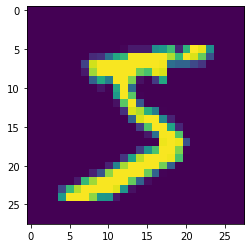

tensor(5)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [8]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Кадр одноканальный:
- добавляем измерение под каналы (оно после батча и перед кадром)
- признаки во флот

В торче размерность входа для 2д свертки (N, C, H, W)

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [10]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        """Все по описанной выше схеме:
        - чтоб сохранить размерность - паддинг 2 (получаем 32х32 как в ориг.алгоритме)
        - вместо свертки на 120 вых.каналов - полносвязный слой на 400х120 входов/выходов
        - для этого тензор вытягивается в 1х1х400
        - без софтмакса, т.к. кросс-энетропия принимает без софтмакса"""
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [12]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [13]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    
    # в loss хранится весь граф вычислений функции потерь, поэтому 
    # аппендить нужно только скопированное на ЦПУ поле .data, чтоб 
    # остальное CUDA могла освободить
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9761)
tensor(0.9835)
tensor(0.9864)
tensor(0.9893)
tensor(0.9887)
tensor(0.9882)
tensor(0.9880)
tensor(0.9901)
tensor(0.9888)
tensor(0.9862)


In [14]:
lenet5.forward(X_test)

tensor([[-2.3109,  0.1138,  1.1233,  ..., 13.6111, -2.4276,  3.2137],
        [ 1.1579, -1.2353, 14.4741,  ..., -4.8807,  3.1475, -2.3309],
        [-2.9998, 14.2202, -1.1490,  ...,  1.5017,  2.1506, -2.0906],
        ...,
        [-3.3096,  0.0390, -4.2435,  ...,  1.5647,  1.4010,  2.4368],
        [-2.9055, -3.3319, -4.1277,  ..., -5.6521,  5.2788, -2.0395],
        [ 1.7145, -4.7581,  0.8094,  ..., -7.4523, -0.5157, -1.6963]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

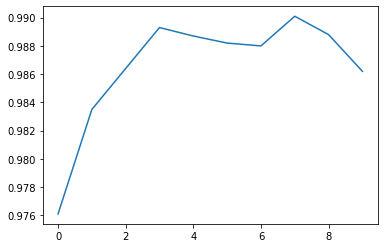

In [16]:
plt.plot(test_accuracy_history);

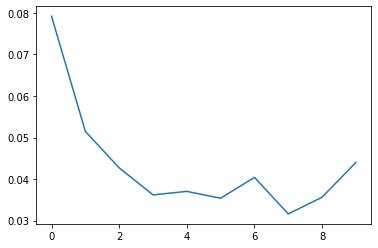

In [17]:
plt.plot(test_loss_history);